In [1]:
# this needs a dbto file that cannot be applied at runtime
# read overl/insert_dtbo.py
# https://discuss.pynq.io/t/pynq3-0-1-allocate-ddr4-returns-buffer-outside-of-address-range/4918/7

# measurement settings
offset_freq = 25e3
trig_val = 1000
delay_ch_2 = 0
phase_mult_ch_2 = 1

In [2]:
from pynq import PL
PL.reset()

import numpy as np
import matplotlib.pyplot as plt
from pynq import allocate
import xrfdc
import time

from overlay.phase_correction_adjustable_overlay import phase_correction_adjustable_overlay
base = phase_correction_adjustable_overlay('overlay/adj.bit')
base.init_rf_clks()

base.ip_dict

{'radio/pc_averager': {'type': 'xilinx.com:hls:pc_averager:1.0',
  'mem_id': 's_axi_control',
  'memtype': 'REGISTER',
  'gpio': {},
  'interrupts': {},
  'parameters': {'C_S_AXI_CONTROL_ADDR_WIDTH': '5',
   'C_S_AXI_CONTROL_DATA_WIDTH': '32',
   'Component_Name': 'adj_pc_averager_0',
   'clk_period': '3.1',
   'machine': '64',
   'combinational': '0',
   'latency': 'undef',
   'II': 'x',
   'EDK_IPTYPE': 'PERIPHERAL',
   'C_S_AXI_CONTROL_BASEADDR': '0xB0000000',
   'C_S_AXI_CONTROL_HIGHADDR': '0xB000FFFF',
   'ADDR_WIDTH': '5',
   'DATA_WIDTH': '32',
   'PROTOCOL': 'AXI4LITE',
   'READ_WRITE_MODE': 'READ_WRITE',
   'FREQ_HZ': '310000000',
   'ID_WIDTH': '0',
   'AWUSER_WIDTH': '0',
   'ARUSER_WIDTH': '0',
   'WUSER_WIDTH': '0',
   'RUSER_WIDTH': '0',
   'BUSER_WIDTH': '0',
   'HAS_BURST': '0',
   'HAS_LOCK': '0',
   'HAS_PROT': '0',
   'HAS_CACHE': '0',
   'HAS_QOS': '0',
   'HAS_REGION': '0',
   'HAS_WSTRB': '1',
   'HAS_BRESP': '1',
   'HAS_RRESP': '1',
   'SUPPORTS_NARROW_BURST': '

result address, something wrong if not >= 0x1000000000:  0x1000000000
measuring
finished
meas no: 1 meas time avg: 4377.0  us  meas time single: 44.0  us


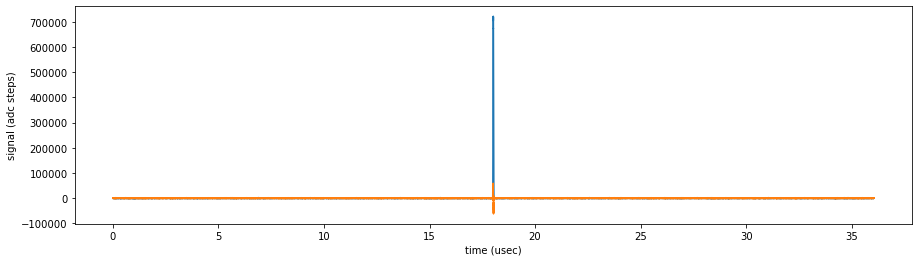

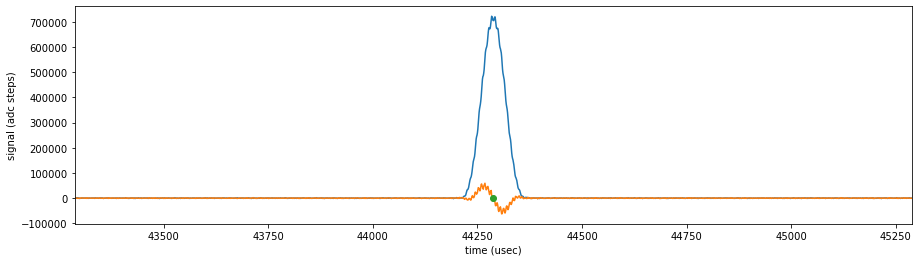

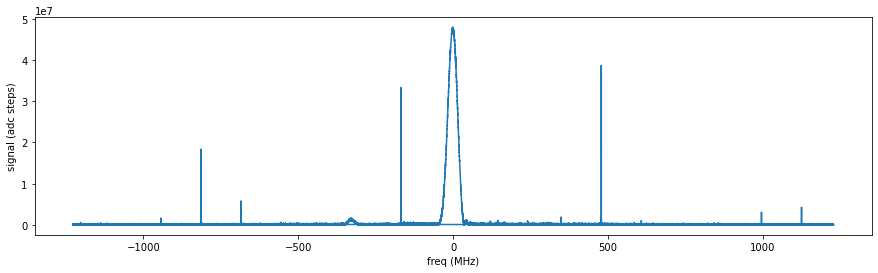

In [3]:
# this needs a dbto file that cannot be applied at runtime
# read overl/insert_dtbo.py
# https://discuss.pynq.io/t/pynq3-0-1-allocate-ddr4-returns-buffer-outside-of-address-range/4918/7
from pynq import PL
PL.reset()

import numpy as np
import matplotlib.pyplot as plt
from pynq import allocate
import xrfdc
import time

from overlay.phase_correction_adjustable_overlay import phase_correction_adjustable_overlay
base = phase_correction_adjustable_overlay('overlay/adj.bit')
base.init_rf_clks()

downsample = 1
base.radio.rfdc.adc_tiles[0].SetupFIFO(0)
time.sleep(0.1)

base.radio.rfdc.adc_tiles[0].blocks[0].MixerSettings['MixerType'] = xrfdc.MIXER_TYPE_COARSE
base.radio.rfdc.adc_tiles[0].blocks[0].MixerSettings['CoarseMixFreq'] = xrfdc.COARSE_MIX_BYPASS

if downsample==1:
    base.radio.rfdc.adc_tiles[0].blocks[0].DecimationFactor = 1
    base.radio.rfdc.adc_tiles[0].FabClkOutDiv = xrfdc.FAB_CLK_DIV2
elif downsample==2:
    base.radio.rfdc.adc_tiles[0].blocks[0].DecimationFactor = 2
    base.radio.rfdc.adc_tiles[0].FabClkOutDiv = xrfdc.FAB_CLK_DIV4
elif downsample==4:
    base.radio.rfdc.adc_tiles[0].blocks[0].DecimationFactor = 4
    base.radio.rfdc.adc_tiles[0].FabClkOutDiv = xrfdc.FAB_CLK_DIV8
elif downsample==8:
    base.radio.rfdc.adc_tiles[0].blocks[0].DecimationFactor = 8
    base.radio.rfdc.adc_tiles[0].FabClkOutDiv = xrfdc.FAB_CLK_DIV16

base.radio.rfdc.adc_tiles[0].blocks[0].FabRdVldWords = 12
base.radio.rfdc.adc_tiles[0].blocks[0].ResetInternalFIFOWidth()
    
time.sleep(0.1)
base.radio.rfdc.adc_tiles[0].SetupFIFO(1)
base.radio.rfdc.adc_tiles[0].StartUp()
time.sleep(0.1)

sampling_rate_in = 4915.2e6 / downsample
sampling_rate_after_hilbert = sampling_rate_in/2
# should be a multiple of 512 (64*8)
ifg_samples = int(sampling_rate_after_hilbert/offset_freq*0.95*0.95/512.)*512

# data type is 2*int32 (real+imag)
data_type = np.int32
result_mem = allocate(shape=(ifg_samples*2,), dtype=data_type, target=base.ddr.ddr4_0)
print('result address, something wrong if not >= 0x1000000000: ', hex(result_mem.physical_address))
result_mem[:] = np.zeros(ifg_samples*2, dtype=data_type)
result_mem.flush()
base.radio.writer_avg.write(base.radio.writer_avg.register_map.result_mem_offset_1.address, int(result_mem.physical_address & 0x00000000ffffffff))
base.radio.writer_avg.write(base.radio.writer_avg.register_map.result_mem_offset_2.address, int(result_mem.physical_address/2**32))

# configure measure worker and averager to the correct sample length and delay and trig value
base.radio.measure_worker.write(base.radio.measure_worker.register_map.num_samples.address, ifg_samples)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.delay_ch_2.address, delay_ch_2)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.phase_mult_ch_2.address, phase_mult_ch_2)
base.radio.trigger_worker.write(base.radio.trigger_worker.register_map.trig_val_sq.address, trig_val**2)
base.radio.pc_averager.write(base.radio.pc_averager.register_map.num_samples.address, ifg_samples)

# configures averages
hardware_avgs = 100
base.radio.pc_averager.write(base.radio.pc_averager.register_map.demanded_avgs.address, hardware_avgs)

# tells writer_avg to write the result (must multiply by 2 because the data type after the averager is twice as long
# as for the orig or orig corrected stream)
base.radio.writer_avg.write(base.radio.writer_avg.register_map.num_samples.address, int(ifg_samples*2))

# turns on all writer ips (and auto restart) (all must be on to avoid backpressure deadlock)
base.radio.pc_averager.write(base.radio.pc_averager.register_map.CTRL.address, 0x81)
base.radio.writer_avg.write(base.radio.writer_avg.register_map.CTRL.address, 0x81)
base.radio.writer_log.write(base.radio.writer_log.register_map.CTRL.address, 0x81)
base.radio.writer_orig.write(base.radio.writer_orig.register_map.CTRL.address, 0x81)
base.radio.writer_orig_corrected.write(base.radio.writer_orig_corrected.register_map.CTRL.address, 0x81)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.CTRL.address, 0x81)

# turns on the data stream
base.radio.input_passer_double.write(base.radio.input_passer_double.register_map.send.address, 1)
# tells averager to write the result
base.radio.writer_avg.write(base.radio.writer_avg.register_map.write_in.address, int(1))
print('measuring')
time_1 = time.time()
while(base.radio.writer_avg.read(base.radio.writer_avg.register_map.write_out.address) < 1):
    pass
time_2 = time.time()
print('finished')
print(
    'meas no:', base.radio.writer_avg.read(base.radio.writer_avg.register_map.write_out.address),
    'meas time avg:', np.round((time_2-time_1)*1e6), ' us ',
    'meas time single:', np.round((time_2-time_1)*1e6/hardware_avgs), ' us')
base.radio.input_passer_double.write(base.radio.input_passer_double.register_map.send.address, 0)

result_mem.invalidate()
data = np.copy(result_mem)
data = data[::2] + 1j*data[1::2]

del result_mem

time_vec = np.arange(0, ifg_samples)/sampling_rate_after_hilbert
freq = np.fft.fftfreq(data.shape[0], d=time_vec[1]-time_vec[0])

plt.figure(figsize=(15,4))
plt.plot(time_vec*1e6, np.real(data))
plt.plot(time_vec*1e6, np.imag(data))
#plt.xlim([0, 1])
#plt.ylim([0, 2000])
plt.xlabel('time (usec)')
plt.ylabel('signal (adc steps)')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(np.real(data))
plt.plot(np.imag(data))
plt.plot(int(data.size/2), 0, 'o')
plt.xlim([int(data.size/2)-1000, int(data.size/2)+1000])
plt.xlabel('time (usec)')
plt.ylabel('signal (adc steps)')
plt.show()

plt.figure(figsize=(15,4))
data_fft = np.fft.fft(data)
plt.plot(freq*1e-6, np.abs(data_fft))
#plt.xlim([0, 1])
plt.xlabel('freq (MHz)')
plt.ylabel('signal (adc steps)')
plt.show()

result address, something wrong if not >= 0x1000000000:  0x1000000000
meas no: 1 meas time avg: 73929.0  us  meas time single: 74.0  us
meas no: 2 meas time avg: 44028.0  us  meas time single: 44.0  us
meas no: 3 meas time avg: 54190.0  us  meas time single: 54.0  us
meas no: 4 meas time avg: 42549.0  us  meas time single: 43.0  us
meas no: 5 meas time avg: 53879.0  us  meas time single: 54.0  us
meas no: 6 meas time avg: 44005.0  us  meas time single: 44.0  us
meas no: 7 meas time avg: 52779.0  us  meas time single: 53.0  us
meas no: 8 meas time avg: 45705.0  us  meas time single: 46.0  us
meas no: 9 meas time avg: 55343.0  us  meas time single: 55.0  us
meas no: 10 meas time avg: 49451.0  us  meas time single: 49.0  us
meas no: 11 meas time avg: 47752.0  us  meas time single: 48.0  us
meas no: 12 meas time avg: 49162.0  us  meas time single: 49.0  us
meas no: 13 meas time avg: 49959.0  us  meas time single: 50.0  us
meas no: 14 meas time avg: 43345.0  us  meas time single: 43.0  us
m

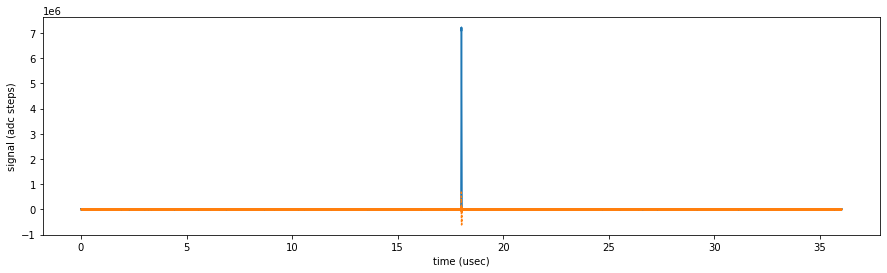

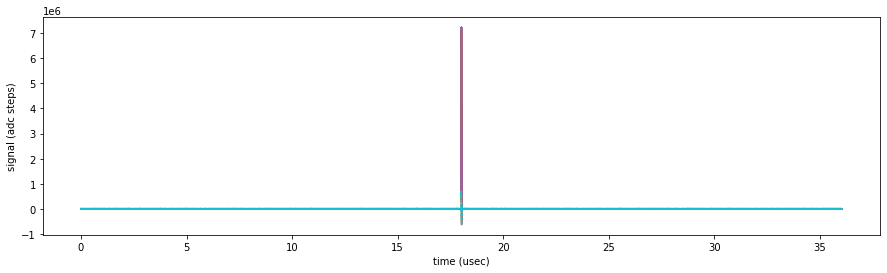

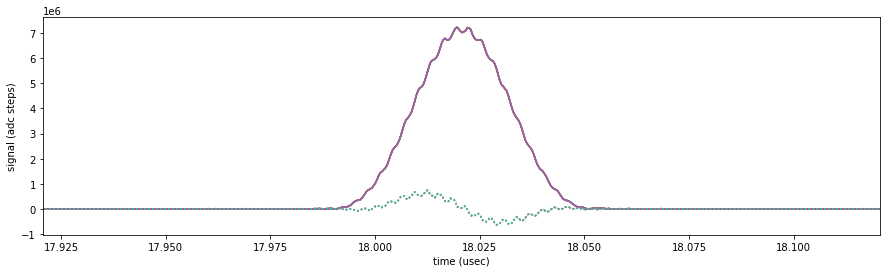

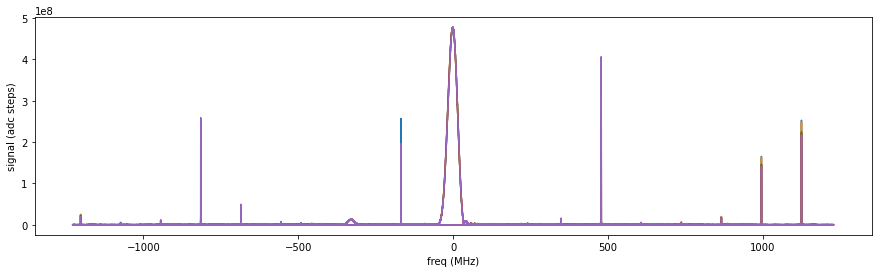

In [11]:
# this needs a dbto file that cannot be applied at runtime
# read overl/insert_dtbo.py
# https://discuss.pynq.io/t/pynq3-0-1-allocate-ddr4-returns-buffer-outside-of-address-range/4918/7
from pynq import PL
PL.reset()

import numpy as np
import matplotlib.pyplot as plt
from pynq import allocate
import xrfdc
import time

from overlay.phase_correction_adjustable_overlay import phase_correction_adjustable_overlay
base = phase_correction_adjustable_overlay('overlay/adj.bit')
base.init_rf_clks()

downsample = 1
base.radio.rfdc.adc_tiles[0].SetupFIFO(0)
time.sleep(0.1)

base.radio.rfdc.adc_tiles[0].blocks[0].MixerSettings['MixerType'] = xrfdc.MIXER_TYPE_COARSE
base.radio.rfdc.adc_tiles[0].blocks[0].MixerSettings['CoarseMixFreq'] = xrfdc.COARSE_MIX_BYPASS

if downsample==1:
    base.radio.rfdc.adc_tiles[0].blocks[0].DecimationFactor = 1
    base.radio.rfdc.adc_tiles[0].FabClkOutDiv = xrfdc.FAB_CLK_DIV2
elif downsample==2:
    base.radio.rfdc.adc_tiles[0].blocks[0].DecimationFactor = 2
    base.radio.rfdc.adc_tiles[0].FabClkOutDiv = xrfdc.FAB_CLK_DIV4
elif downsample==4:
    base.radio.rfdc.adc_tiles[0].blocks[0].DecimationFactor = 4
    base.radio.rfdc.adc_tiles[0].FabClkOutDiv = xrfdc.FAB_CLK_DIV8
elif downsample==8:
    base.radio.rfdc.adc_tiles[0].blocks[0].DecimationFactor = 8
    base.radio.rfdc.adc_tiles[0].FabClkOutDiv = xrfdc.FAB_CLK_DIV16

base.radio.rfdc.adc_tiles[0].blocks[0].FabRdVldWords = 12
base.radio.rfdc.adc_tiles[0].blocks[0].ResetInternalFIFOWidth()
    
time.sleep(0.1)
base.radio.rfdc.adc_tiles[0].SetupFIFO(1)
base.radio.rfdc.adc_tiles[0].StartUp()
time.sleep(0.1)

sampling_rate_in = 4915.2e6 / downsample
sampling_rate_after_hilbert = sampling_rate_in/2
# should be a multiple of 512 (64*8)
ifg_samples = int(sampling_rate_after_hilbert/offset_freq*0.95*0.95/512.)*512

# data type is 2*int32 (real+imag)
data_type = np.int32
result_mem = allocate(shape=(ifg_samples*2,), dtype=data_type, target=base.ddr.ddr4_0)
print('result address, something wrong if not >= 0x1000000000: ', hex(result_mem.physical_address))
result_mem[:] = np.zeros(ifg_samples*2, dtype=data_type)
result_mem.flush()
base.radio.writer_avg.write(base.radio.writer_avg.register_map.result_mem_offset_1.address, int(result_mem.physical_address & 0x00000000ffffffff))
base.radio.writer_avg.write(base.radio.writer_avg.register_map.result_mem_offset_2.address, int(result_mem.physical_address/2**32))

# configure measure worker and averager to the correct sample length and delay and trig value
base.radio.measure_worker.write(base.radio.measure_worker.register_map.num_samples.address, ifg_samples)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.delay_ch_2.address, delay_ch_2)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.phase_mult_ch_2.address, phase_mult_ch_2)
base.radio.trigger_worker.write(base.radio.trigger_worker.register_map.trig_val_sq.address, trig_val**2)
base.radio.pc_averager.write(base.radio.pc_averager.register_map.num_samples.address, ifg_samples)

# configures averages
hardware_avgs = 1000
base.radio.pc_averager.write(base.radio.pc_averager.register_map.demanded_avgs.address, hardware_avgs)

# tells writer_avg to write the result (must multiply by 2 because the data type after the averager is twice as long
# as for the orig or orig corrected stream)
base.radio.writer_avg.write(base.radio.writer_avg.register_map.num_samples.address, int(ifg_samples*2))

# turns on all writer ips (and auto restart) (all must be on to avoid backpressure deadlock)
base.radio.pc_averager.write(base.radio.pc_averager.register_map.CTRL.address, 0x81)
base.radio.writer_avg.write(base.radio.writer_avg.register_map.CTRL.address, 0x81)
base.radio.writer_log.write(base.radio.writer_log.register_map.CTRL.address, 0x81)
base.radio.writer_orig.write(base.radio.writer_orig.register_map.CTRL.address, 0x81)
base.radio.writer_orig_corrected.write(base.radio.writer_orig_corrected.register_map.CTRL.address, 0x81)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.CTRL.address, 0x81)

# array to save the result (only needed for software averaging)
software_averages = 20
data = np.zeros([ifg_samples*2, software_averages])
# turns on the data stream
base.radio.input_passer_double.write(base.radio.input_passer_double.register_map.send.address, 1)
# it takes about 25 ms to read the result to the processing part
# therefore, reasonable software averaging is only possible beyond 500 hardware averages 
# at 20 kHz an no decimation
for cnt in np.arange(0, software_averages): # writing only starts when sending 1
    
    time_1 = time.time()
    # tells averager to write the result
    base.radio.writer_avg.write(base.radio.writer_avg.register_map.write_in.address, int(cnt+1))
    while(base.radio.writer_avg.read(base.radio.writer_avg.register_map.write_out.address) < cnt+1):
        pass
    
    result_mem.invalidate()
    data[:, cnt] = np.copy(result_mem)
    time_2 = time.time()

    if np.mod(cnt, 1)==0:
        print(
            'meas no:', base.radio.writer_avg.read(base.radio.writer_avg.register_map.write_out.address),
            'meas time avg:', np.round((time_2-time_1)*1e6), ' us ',
            'meas time single:', np.round((time_2-time_1)*1e6/hardware_avgs), ' us')
base.radio.input_passer_double.write(base.radio.input_passer_double.register_map.send.address, 0)

del result_mem

data = data[::2, :] + 1j*data[1::2, :]

# np.save('data/cross_r_g_iod/data_ch1_' + str(hardware_avgs)+ '_avgs_x' + str(software_averages), data)

time_vec = np.arange(0, ifg_samples)/sampling_rate_after_hilbert
freq = np.fft.fftfreq(data.shape[0], d=time_vec[1]-time_vec[0])

datam = np.mean(data, axis=1)
plt.figure(figsize=(15,4))
plt.plot(time_vec*1e6, np.real(datam))
plt.plot(time_vec*1e6, np.imag(datam), ':')
#plt.xlim([0, 1])
plt.xlabel('time (usec)')
plt.ylabel('signal (adc steps)')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(time_vec*1e6, np.real(data[:, 0:5]))
plt.plot(time_vec*1e6, np.imag(data[:, 0:5]), ':')
#plt.xlim([0, 1])
plt.xlabel('time (usec)')
plt.ylabel('signal (adc steps)')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(time_vec*1e6, np.real(data[:, 0:5]))
plt.plot(time_vec*1e6, np.imag(data[:, 0:5]), ':')
plt.xlim([np.max(time_vec*1e6)/2-0.1, np.max(time_vec*1e6)/2+0.1])
plt.xlabel('time (usec)')
plt.ylabel('signal (adc steps)')
plt.show()

plt.figure(figsize=(15,4))
data_fft = np.fft.fft(data[:, 0:5], axis=0)
plt.plot(freq*1e-6, np.abs(data_fft[:, 0:5]))
#plt.xlim([0, 1])
plt.xlabel('freq (MHz)')
plt.ylabel('signal (adc steps)')
plt.show()


address, something wrong if not > 0x1000000000:  0x1000000000
measuring
finished


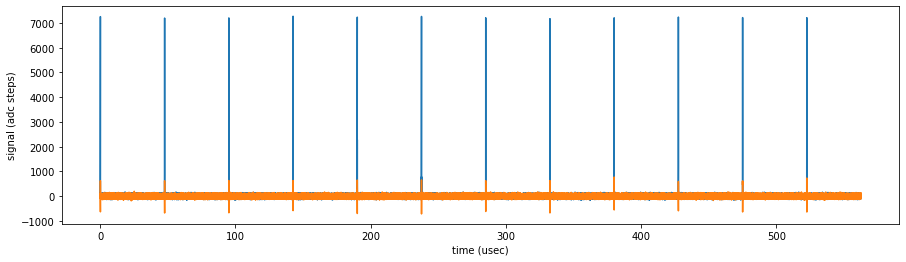

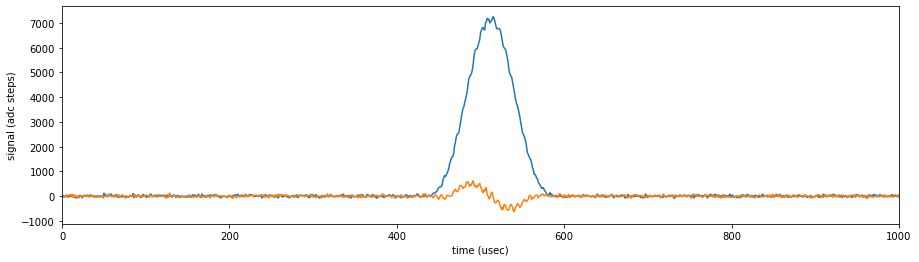

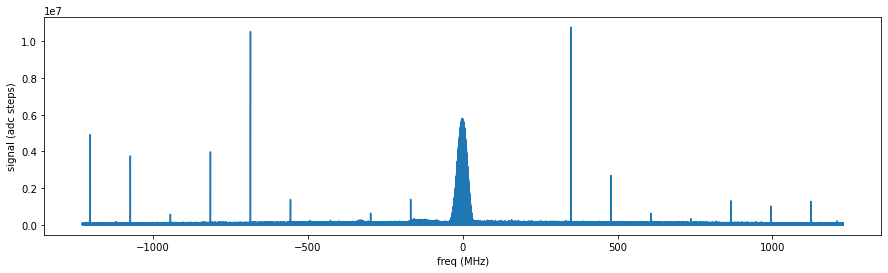

In [5]:
from pynq import PL
PL.reset()

import numpy as np
import matplotlib.pyplot as plt
from pynq import allocate
import xrfdc
import time

from overlay.phase_correction_adjustable_overlay import phase_correction_adjustable_overlay
base = phase_correction_adjustable_overlay('overlay/adj.bit')
base.init_rf_clks()

downsample = 1
base.radio.rfdc.adc_tiles[0].SetupFIFO(0)
time.sleep(0.1)

base.radio.rfdc.adc_tiles[0].blocks[0].MixerSettings['MixerType'] = xrfdc.MIXER_TYPE_COARSE
base.radio.rfdc.adc_tiles[0].blocks[0].MixerSettings['CoarseMixFreq'] = xrfdc.COARSE_MIX_BYPASS

if downsample==1:
    base.radio.rfdc.adc_tiles[0].blocks[0].DecimationFactor = 1
    base.radio.rfdc.adc_tiles[0].FabClkOutDiv = xrfdc.FAB_CLK_DIV2
elif downsample==2:
    base.radio.rfdc.adc_tiles[0].blocks[0].DecimationFactor = 2
    base.radio.rfdc.adc_tiles[0].FabClkOutDiv = xrfdc.FAB_CLK_DIV4
elif downsample==4:
    base.radio.rfdc.adc_tiles[0].blocks[0].DecimationFactor = 4
    base.radio.rfdc.adc_tiles[0].FabClkOutDiv = xrfdc.FAB_CLK_DIV8
elif downsample==8:
    base.radio.rfdc.adc_tiles[0].blocks[0].DecimationFactor = 8
    base.radio.rfdc.adc_tiles[0].FabClkOutDiv = xrfdc.FAB_CLK_DIV16

base.radio.rfdc.adc_tiles[0].blocks[0].FabRdVldWords = 12
base.radio.rfdc.adc_tiles[0].blocks[0].ResetInternalFIFOWidth()
    
time.sleep(0.1)
base.radio.rfdc.adc_tiles[0].SetupFIFO(1)
base.radio.rfdc.adc_tiles[0].StartUp()
time.sleep(0.1)

sampling_rate_in = 4915.2e6 / downsample
sampling_rate_after_hilbert = sampling_rate_in/2

# should be a multiple of 1024 (64*16)
num_write_samples = int(27*512*10*10)  # 500 for pub
# data type is 2*int16 (real+imag)
num_write_values = int(num_write_samples*2)
data_type = np.int16

# allocates a ddr buffer
result_mem = allocate(shape=(num_write_values,), dtype=data_type, target=base.ddr.ddr4_0)
print('address, something wrong if not > 0x1000000000: ', hex(result_mem.physical_address))
result_mem[:] = np.zeros(num_write_values, dtype=data_type)
result_mem.flush()
base.radio.writer_orig_corrected.write(base.radio.writer_orig_corrected.register_map.result_mem_offset_1.address, int(result_mem.physical_address & 0x00000000ffffffff))
base.radio.writer_orig_corrected.write(base.radio.writer_orig_corrected.register_map.result_mem_offset_2.address, int(result_mem.physical_address/2**32))

# configure measure worker and averager to the correct sample length and delay
# num samples must be set but doesnt matter
base.radio.measure_worker.write(base.radio.measure_worker.register_map.num_samples.address, 1024)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.delay_ch_2.address, delay_ch_2)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.phase_mult_ch_2.address, phase_mult_ch_2)
base.radio.trigger_worker.write(base.radio.trigger_worker.register_map.trig_val_sq.address, trig_val**2)

# configures averages (set demanded_avgs to >0 to avoid memory access but must set num_samples to avoid backpressure)
# num samples must be set but doesnt matter
base.radio.pc_averager.write(base.radio.pc_averager.register_map.num_samples.address, 1024)
base.radio.pc_averager.write(base.radio.pc_averager.register_map.demanded_avgs.address, 1024)

# tells writer_orig_corrected to write the result
base.radio.writer_orig_corrected.write(base.radio.writer_orig_corrected.register_map.num_samples.address, int(num_write_samples))
base.radio.writer_orig_corrected.write(base.radio.writer_orig_corrected.register_map.write_in.address, 1)

# turns on all writer ips (and auto restart) (all must be on to avoid backpressure deadlock)
base.radio.pc_averager.write(base.radio.pc_averager.register_map.CTRL.address, 0x81)
base.radio.writer_avg.write(base.radio.writer_avg.register_map.CTRL.address, 0x81)
base.radio.writer_log.write(base.radio.writer_log.register_map.CTRL.address, 0x81)
base.radio.writer_orig.write(base.radio.writer_orig.register_map.CTRL.address, 0x81)
base.radio.writer_orig_corrected.write(base.radio.writer_orig_corrected.register_map.CTRL.address, 0x81)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.CTRL.address, 0x81)

# turns on the data stream
print('measuring')
base.radio.input_passer_double.write(base.radio.input_passer_double.register_map.send.address, 1)
while(base.radio.writer_orig_corrected.read(base.radio.writer_orig_corrected.register_map.write_out.address) < 1):
    pass
base.radio.input_passer_double.write(base.radio.input_passer_double.register_map.send.address, 0)
print('finished')

result_mem.invalidate()
data = np.copy(result_mem)

del result_mem

data = data[::2] + 1j*data[1::2]

time_vec = np.arange(0, num_write_samples)/sampling_rate_after_hilbert
freq = np.fft.fftfreq(data.shape[0], d=time_vec[1]-time_vec[0])

if 1:
    plt.figure(figsize=(15,4))
    plt.plot(time_vec*1e6, np.real(data))
    plt.plot(time_vec*1e6, np.imag(data))
    #plt.xlim([0, 1])
    plt.xlabel('time (usec)')
    plt.ylabel('signal (adc steps)')
    plt.show()
    
    plt.figure(figsize=(15,4))
    plt.plot(np.real(data))
    plt.plot(np.imag(data))
    plt.xlim([0, 1000])
    plt.xlabel('time (usec)')
    plt.ylabel('signal (adc steps)')
    plt.show()

    plt.figure(figsize=(15,4))
    data_fft = np.fft.fft(data)
    plt.plot(freq*1e-6, np.abs(data_fft))
    #plt.xlim([0, 1])
    plt.xlabel('freq (MHz)')
    plt.ylabel('signal (adc steps)')
    plt.show()

#np.save('data/cross_r_g/data_ch1_orig_corrected', data)
#np.save('data/cross_r_g/data_ch2_orig_corrected', data2)


address, something wrong if not > 0x1000000000:  0x1000000000
measuring
finished


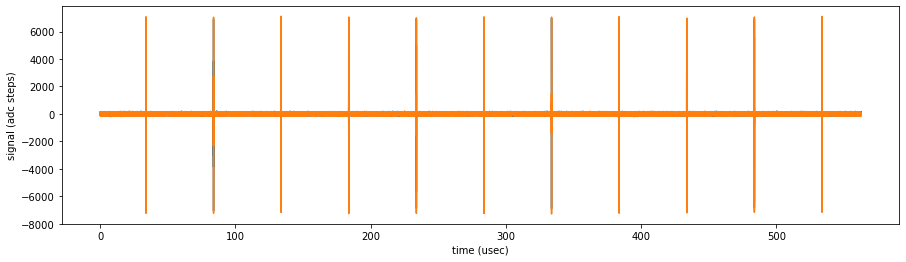

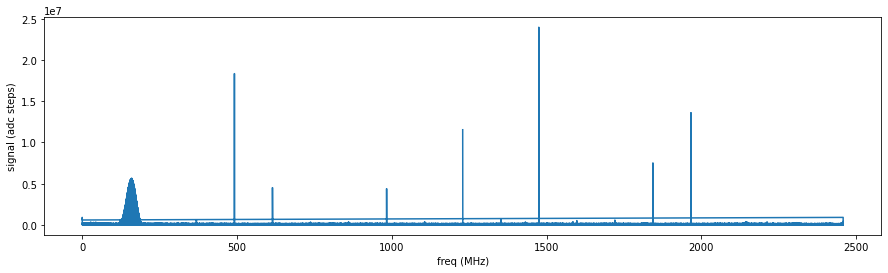

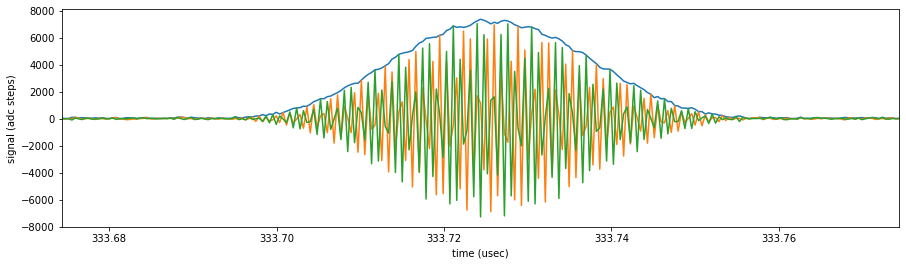

In [6]:
from pynq import PL
PL.reset()

import numpy as np
import matplotlib.pyplot as plt
from pynq import allocate
import xrfdc
import time

from overlay.phase_correction_adjustable_overlay import phase_correction_adjustable_overlay
base = phase_correction_adjustable_overlay('overlay/adj.bit')
base.init_rf_clks()

downsample = 1
base.radio.rfdc.adc_tiles[0].SetupFIFO(0)
time.sleep(0.1)

base.radio.rfdc.adc_tiles[0].blocks[0].MixerSettings['MixerType'] = xrfdc.MIXER_TYPE_COARSE
base.radio.rfdc.adc_tiles[0].blocks[0].MixerSettings['CoarseMixFreq'] = xrfdc.COARSE_MIX_BYPASS

if downsample==1:
    base.radio.rfdc.adc_tiles[0].blocks[0].DecimationFactor = 1
    base.radio.rfdc.adc_tiles[0].FabClkOutDiv = xrfdc.FAB_CLK_DIV2
elif downsample==2:
    base.radio.rfdc.adc_tiles[0].blocks[0].DecimationFactor = 2
    base.radio.rfdc.adc_tiles[0].FabClkOutDiv = xrfdc.FAB_CLK_DIV4
elif downsample==4:
    base.radio.rfdc.adc_tiles[0].blocks[0].DecimationFactor = 4
    base.radio.rfdc.adc_tiles[0].FabClkOutDiv = xrfdc.FAB_CLK_DIV8
elif downsample==8:
    base.radio.rfdc.adc_tiles[0].blocks[0].DecimationFactor = 8
    base.radio.rfdc.adc_tiles[0].FabClkOutDiv = xrfdc.FAB_CLK_DIV16

base.radio.rfdc.adc_tiles[0].blocks[0].FabRdVldWords = 12
base.radio.rfdc.adc_tiles[0].blocks[0].ResetInternalFIFOWidth()
    
time.sleep(0.1)
base.radio.rfdc.adc_tiles[0].SetupFIFO(1)
base.radio.rfdc.adc_tiles[0].StartUp()
time.sleep(0.1)

sampling_rate_in = 4915.2e6 / downsample
sampling_rate_after_hilbert = sampling_rate_in / 2

# should be a multiple of 1024 (64*16)
num_write_samples = int(27*512*10*10)  # 500 for pub
# data type is 2*int16 (real+imag)
num_write_values = int(num_write_samples*2)
data_type = np.int16

# allocates a ddr buffer
result_mem = allocate(shape=(num_write_values,), dtype=data_type, target=base.ddr.ddr4_0)
print('address, something wrong if not > 0x1000000000: ', hex(result_mem.physical_address))
result_mem[:] = np.zeros(num_write_values, dtype=data_type)
result_mem.flush()
base.radio.writer_orig.write(base.radio.writer_orig.register_map.result_mem_offset_1.address, int(result_mem.physical_address & 0x00000000ffffffff))
base.radio.writer_orig.write(base.radio.writer_orig.register_map.result_mem_offset_2.address, int(result_mem.physical_address/2**32))

# configure measure worker and averager to the correct sample length and delay
# num samples must be set but doesnt matter
base.radio.measure_worker.write(base.radio.measure_worker.register_map.num_samples.address, 1024)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.delay_ch_2.address, delay_ch_2)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.phase_mult_ch_2.address, phase_mult_ch_2)
base.radio.trigger_worker.write(base.radio.trigger_worker.register_map.trig_val_sq.address, trig_val**2)

# configures averages (set demanded_avgs to 0> to avoid memory access but must set num_samples to avoid backpressure)
# num samples must be set but doesnt matter
base.radio.pc_averager.write(base.radio.pc_averager.register_map.num_samples.address, 1024)
base.radio.pc_averager.write(base.radio.pc_averager.register_map.demanded_avgs.address, 1024)

# tells writer_orig to write the result
base.radio.writer_orig.write(base.radio.writer_orig.register_map.num_samples.address, int(num_write_samples))
base.radio.writer_orig.write(base.radio.writer_orig.register_map.write_in.address, 1)

# turns on all writer ips (and auto restart) (all must be on to avoid backpressure deadlock)
base.radio.pc_averager.write(base.radio.pc_averager.register_map.CTRL.address, 0x81)
base.radio.writer_avg.write(base.radio.writer_avg.register_map.CTRL.address, 0x81)
base.radio.writer_log.write(base.radio.writer_log.register_map.CTRL.address, 0x81)
base.radio.writer_orig.write(base.radio.writer_orig.register_map.CTRL.address, 0x81)
base.radio.writer_orig_corrected.write(base.radio.writer_orig_corrected.register_map.CTRL.address, 0x81)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.CTRL.address, 0x81)

# turns on the data stream
print('measuring')
base.radio.input_passer_double.write(base.radio.input_passer_double.register_map.send.address, 1)
while(base.radio.writer_orig.read(base.radio.writer_orig.register_map.write_out.address) < 1):
    pass
base.radio.input_passer_double.write(base.radio.input_passer_double.register_map.send.address, 0)
print('finished')

result_mem.invalidate()
data = np.copy(result_mem)

del result_mem

data = data[::2] + 1j*data[1::2]

time_vec = np.arange(0, num_write_samples)/sampling_rate_after_hilbert
freq = np.fft.fftfreq(data.shape[0], d=time_vec[1]-time_vec[0])+sampling_rate_after_hilbert/2

if 1:
    plt.figure(figsize=(15,4))
    plt.plot(time_vec*1e6, np.real(data))
    plt.plot(time_vec*1e6, np.imag(data))
    #plt.xlim([0, 1])
    plt.xlabel('time (usec)')
    plt.ylabel('signal (adc steps)')
    plt.show()

    plt.figure(figsize=(15,4))
    data_fft = np.fft.fft(data)
    plt.plot(freq*1e-6, np.abs(data_fft))
    #plt.xlim([0, 1])
    plt.xlabel('freq (MHz)')
    plt.ylabel('signal (adc steps)')
    plt.show()
    
    plt.figure(figsize=(15,4))
    plt.plot(time_vec*1e6, np.abs(data))
    plt.plot(time_vec*1e6, np.real(data))
    plt.plot(time_vec*1e6, np.imag(data))
    m = np.argmax(np.abs(data))
    plt.xlim([time_vec[m]*1e6-0.05, time_vec[m]*1e6+0.05])
    plt.xlabel('time (usec)')
    plt.ylabel('signal (adc steps)')
    plt.show()
    
#np.save('data/cross_r_g/data_ch1_orig', data)
#np.save('data/cross_r_g/data_ch2_orig', data2)

address, something wrong if not > 0x1000000000:  0x1000000000
measuring
finished


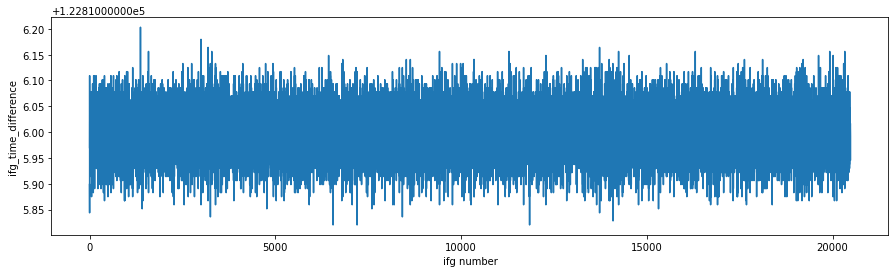

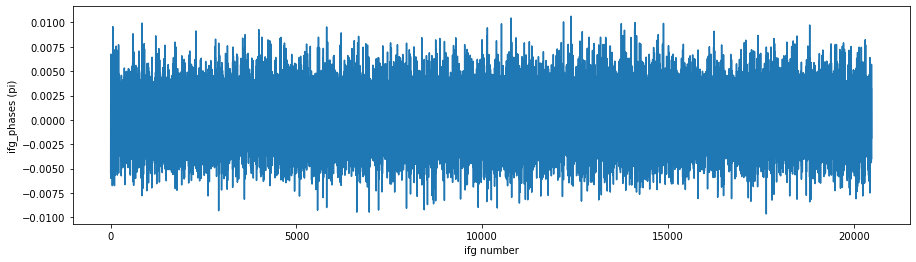

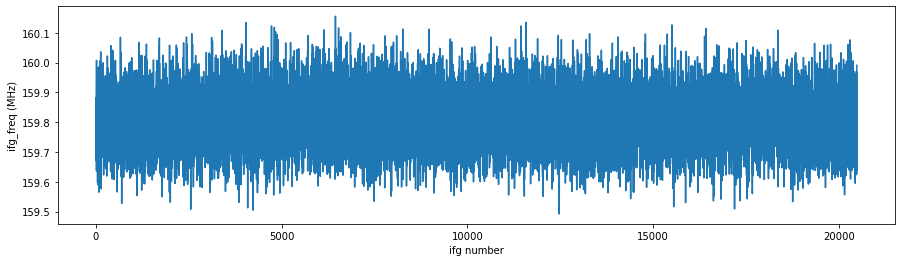

In [7]:
from pynq import PL
PL.reset()

import numpy as np
import matplotlib.pyplot as plt
from pynq import allocate
import xrfdc
import time

from overlay.phase_correction_adjustable_overlay import phase_correction_adjustable_overlay
base = phase_correction_adjustable_overlay('overlay/adj.bit')

base.init_rf_clks()

downsample = 1
base.radio.rfdc.adc_tiles[0].SetupFIFO(0)
time.sleep(0.1)

base.radio.rfdc.adc_tiles[0].blocks[0].MixerSettings['MixerType'] = xrfdc.MIXER_TYPE_COARSE
base.radio.rfdc.adc_tiles[0].blocks[0].MixerSettings['CoarseMixFreq'] = xrfdc.COARSE_MIX_BYPASS

if downsample==1:
    base.radio.rfdc.adc_tiles[0].blocks[0].DecimationFactor = 1
    base.radio.rfdc.adc_tiles[0].FabClkOutDiv = xrfdc.FAB_CLK_DIV2
elif downsample==2:
    base.radio.rfdc.adc_tiles[0].blocks[0].DecimationFactor = 2
    base.radio.rfdc.adc_tiles[0].FabClkOutDiv = xrfdc.FAB_CLK_DIV4
elif downsample==4:
    base.radio.rfdc.adc_tiles[0].blocks[0].DecimationFactor = 4
    base.radio.rfdc.adc_tiles[0].FabClkOutDiv = xrfdc.FAB_CLK_DIV8
elif downsample==8:
    base.radio.rfdc.adc_tiles[0].blocks[0].DecimationFactor = 8
    base.radio.rfdc.adc_tiles[0].FabClkOutDiv = xrfdc.FAB_CLK_DIV16

base.radio.rfdc.adc_tiles[0].blocks[0].FabRdVldWords = 12
base.radio.rfdc.adc_tiles[0].blocks[0].ResetInternalFIFOWidth()
    
time.sleep(0.1)
base.radio.rfdc.adc_tiles[0].SetupFIFO(1)
base.radio.rfdc.adc_tiles[0].StartUp()
time.sleep(0.1)

sampling_rate_in = 4915.2e6 / downsample
sampling_rate_after_hilbert = sampling_rate_in / 2

# should be a multiple of 1024 (64*16)
num_write_samples = int(1024*20)
# data type is float32*4 (4 different quantities)
num_write_values = int(num_write_samples*4)
data_type = np.float32

# allocates a ddr buffer
result_mem = allocate(shape=(num_write_values,), dtype=data_type, target=base.ddr.ddr4_0)
print('address, something wrong if not > 0x1000000000: ', hex(result_mem.physical_address))
result_mem[:] = np.zeros(num_write_values, dtype=data_type)
result_mem.flush()
base.radio.writer_log.write(base.radio.writer_log.register_map.result_mem_offset_1.address, int(result_mem.physical_address & 0x00000000ffffffff))
base.radio.writer_log.write(base.radio.writer_log.register_map.result_mem_offset_2.address, int(result_mem.physical_address/2**32))

# configure measure worker and averager to the correct sample length
# num samples must be set but doesnt matter
base.radio.measure_worker.write(base.radio.measure_worker.register_map.num_samples.address, 1024)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.delay_ch_2.address, delay_ch_2)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.phase_mult_ch_2.address, phase_mult_ch_2)
base.radio.trigger_worker.write(base.radio.trigger_worker.register_map.trig_val_sq.address, trig_val**2)

# configures averages (set to 0 to avoid memory access)
# num samples must be set but doesnt matter
base.radio.pc_averager.write(base.radio.pc_averager.register_map.num_samples.address, 1024)
base.radio.pc_averager.write(base.radio.pc_averager.register_map.demanded_avgs.address, 1024)

# set up num_samples (all must be set to at least 16 to avoid backpressure deadlock)
# re-uses the other writer, which sends 16 samples at once; log also sends 16 samples per write
# tells writer_log to write the result
base.radio.writer_log.write(base.radio.writer_log.register_map.num_samples.address, num_write_values)
base.radio.writer_log.write(base.radio.writer_log.register_map.write_in.address, 1)

# turns on all writer ips (and auto restart) (all must be on to avoid backpressure deadlock)
base.radio.pc_averager.write(base.radio.pc_averager.register_map.CTRL.address, 0x81)
base.radio.writer_avg.write(base.radio.writer_avg.register_map.CTRL.address, 0x81)
base.radio.writer_log.write(base.radio.writer_log.register_map.CTRL.address, 0x81)
base.radio.writer_orig.write(base.radio.writer_orig.register_map.CTRL.address, 0x81)
base.radio.writer_orig_corrected.write(base.radio.writer_orig_corrected.register_map.CTRL.address, 0x81)
base.radio.measure_worker.write(base.radio.measure_worker.register_map.CTRL.address, 0x81)

# turns on the data stream
print('measuring')
base.radio.input_passer_double.write(base.radio.input_passer_double.register_map.send.address, 1)
while(base.radio.writer_log.read(base.radio.writer_log.register_map.write_out.address) < 1):
    pass
base.radio.input_passer_double.write(base.radio.input_passer_double.register_map.send.address, 0)
print('finished')

result_mem.invalidate()
data = np.copy(result_mem)

del result_mem

delta_times = data[::4]
phases = data[1::4]
center_freqs = data[2::4]
spacers = data[3::4]

plt.figure(figsize=(15,4))
plt.plot(delta_times)
#plt.xlim([-10, 1000])
plt.xlabel('ifg number')
plt.ylabel('ifg_time_difference')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(np.diff(np.unwrap(phases*np.pi))/np.pi)
#plt.xlim([-10, 1000])
plt.xlabel('ifg number')
plt.ylabel('ifg_phases (pi)')
plt.show()

plt.figure(figsize=(15,4))
plt.plot((center_freqs*sampling_rate_after_hilbert+sampling_rate_after_hilbert/2)/1e6)
#plt.xlim([-10, 1000])
plt.xlabel('ifg number')
plt.ylabel('ifg_freq (MHz)')
plt.show()